### **Experiments**

In [1]:
import sys
import os
import pickle
sys.path.append('../')
sys.path.append('../nn_survival_analysis')

In [2]:
from nn_survival_analysis.general_utils import *
from nn_survival_analysis.model_utils import *
from nn_survival_analysis.losses import *
from nn_survival_analysis.models import *
from nn_survival_analysis.other_nn_models import *
from nn_survival_analysis.time_invariant_surv import *
from nn_survival_analysis.time_variant_surv import *
from nn_survival_analysis.traditional_models import *

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


### **Load Data for TIS**

In [3]:
# Read the pickled DataFrames
with open('../05_preprocessing_emr_data/data/x_train.pickle', 'rb') as file:
    x_train = pickle.load(file)
with open('../05_preprocessing_emr_data/data/x_test.pickle', 'rb') as file:
    x_test = pickle.load(file)
with open('../05_preprocessing_emr_data/data/x_val.pickle', 'rb') as file:
    x_val = pickle.load(file)
# Get configs
with open('../nn_survival_analysis/config.json', "r") as file:
    configs = json.load(file)

### **Testing Time-Invariant Performance**

In [4]:
#-----------------------------------------------------------------------------------------------
# instantiate - Time Invariant Survival
tis = Time_Invariant_Survival(
        configs = configs, 
        train_data = x_train,
        test_data = x_test, 
        val_data = x_val
)

# fit
tis.fit(verbose = True)
mean_ , up_ , low_ , y_test_dur , y_test_event = tis.predict() # Visualize -> tis.visualize(mean_ , up_ , low_ , _from = 40 , _to = 50 )
tis_cindex , tis_ibs = tis.evaluation(mean_ , y_test_dur , y_test_event, plot = False)    

training cluster 0
Epoch 50: Training Loss: -0.0004460, Val Loss: 0.0033232
Epoch 100: Training Loss: 0.0026795, Val Loss: 0.0010117
Epoch 150: Training Loss: 0.0012533, Val Loss: -0.0004708
Epoch 200: Training Loss: -0.0053277, Val Loss: -0.0003173
Epoch 250: Training Loss: -0.0013284, Val Loss: -0.0014054
Epoch 300: Training Loss: -0.0071553, Val Loss: -0.0019198
Epoch 350: Training Loss: -0.0041237, Val Loss: 0.0005913
Epoch 400: Training Loss: -0.0105718, Val Loss: -0.0011580
shapes : (1060, 1060, 1060, 1060)


In [5]:
tis_cindex , tis_ibs

(0.6895818193829689, 0.3899501849786396)

### **Load Data for TVS**

In [8]:
# Read the pickled DataFrames
with open('../05_preprocessing_emr_data/data/x_train_reshape_tv.pickle', 'rb') as file:
    x_train_reshape_tv = pickle.load(file)
with open('../05_preprocessing_emr_data/data/x_test_reshape_tv.pickle', 'rb') as file:
    x_test_reshape_tv = pickle.load(file)
with open('../05_preprocessing_emr_data/data/x_val_reshape_tv.pickle', 'rb') as file:
    x_val_reshape_tv = pickle.load(file)

# Read the pickled targets
with open('../05_preprocessing_emr_data/data/y_train.pickle', 'rb') as file:
    y_train = pickle.load(file)
with open('../05_preprocessing_emr_data/data/y_test.pickle', 'rb') as file:
    y_test = pickle.load(file)
with open('../05_preprocessing_emr_data/data/y_val.pickle', 'rb') as file:
    y_val = pickle.load(file)

### **Testing Time-Variant Performance**

In [9]:
#-----------------------------------------------------------------------------------------------
# instantiate - Time Variant Survival
tvs = Time_Variant_Survival(
            configs = configs, 
            x_train_reshape_tv = x_train_reshape_tv,
            x_test_reshape_tv = x_test_reshape_tv, 
            x_val_reshape_tv = x_val_reshape_tv,
            y_train = y_train,
            y_test = y_test,
            y_val = y_val
)

# fit
tvs.fit(verbose = True)
mean_ , up_ , low_ , y_test_dur , y_test_event = tvs.predict() # Visualize -> tis.visualize(mean_ , up_ , low_ , _from = 40 , _to = 50 )
tvs_cindex , tvs_ibs = tvs.evaluation(mean_ , y_test_dur , y_test_event, plot = False)

Epoch 50: Training Loss: -0.0025976, Val Loss: 0.0015660
Epoch 100: Training Loss: 0.0000589, Val Loss: 0.0010896
shapes : (1180, 1180, 1180, 1180)


In [10]:
tvs_cindex , tvs_ibs

(0.7335313759085885, 0.40075786613809444)

### **Trying with different cluster size**

In [28]:
# configs['time_invariant']['training']['clusters'] = 1

In [29]:
#-----------------------------------------------------------------------------------------------
# instantiate - Time Invariant Survival
tis = Time_Invariant_Survival(
        configs = configs, 
        train_data = x_train,
        test_data = x_test, 
        val_data = x_val
)

# fit
tis.fit(verbose = False)
mean_ , up_ , low_ , y_test_dur , y_test_event = tis.predict() # Visualize -> tis.visualize(mean_ , up_ , low_ , _from = 40 , _to = 50 )
tis_cindex , tis_ibs = tis.evaluation(mean_ , y_test_dur , y_test_event, plot = False)

shapes : (1060, 1060, 1060, 1060)


In [30]:
tis_cindex , tis_ibs

(0.6887229966307723, 0.4019491137098817)

### **Adding PCA to reduce number of components**

In [69]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1)

In [70]:
# strip of target cols
feed_to_pca = lambda x:x.iloc[: , :-2]

x_train_b4_pca = feed_to_pca(x_train)
x_test_b4_pca = feed_to_pca(x_test)
x_val_b4_pca = feed_to_pca(x_val)

In [71]:
x_train_pca_0 = pd.DataFrame(pca.fit_transform(x_train_b4_pca))
x_test_pca_0 = pd.DataFrame(pca.fit_transform(x_test_b4_pca))
x_val_pca_0 = pd.DataFrame(pca.fit_transform(x_val_b4_pca))

In [72]:
# Check variance captured
np.sum(pca.explained_variance_ratio_)

0.31334215

In [73]:
x_train_pca = pd.concat([x_train_pca_0 , x_train.iloc[: , -2:]] , axis = 1)
x_test_pca = pd.concat([x_test_pca_0 , x_test.iloc[: , -2:]] , axis = 1)
x_val_pca = pd.concat([x_val_pca_0 , x_val.iloc[: , -2:]] , axis = 1)

In [74]:
#-----------------------------------------------------------------------------------------------
# instantiate - Time Invariant Survival
tis = Time_Invariant_Survival(
        configs = configs, 
        train_data = x_train_pca,
        test_data = x_test_pca, 
        val_data = x_val_pca
)

# fit
tis.fit(verbose = False)
mean_ , up_ , low_ , y_test_dur , y_test_event = tis.predict() # Visualize -> tis.visualize(mean_ , up_ , low_ , _from = 40 , _to = 50 )
tis_cindex , tis_ibs = tis.evaluation(mean_ , y_test_dur , y_test_event, plot = False)

shapes : (1060, 1060, 1060, 1060)


In [75]:
tis_cindex , tis_ibs

(0.4891259826914184, 0.4147688930722147)

### **PCA & Clustering**

In [4]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

# strip of target cols
feed_to_pca = lambda x:x.iloc[: , :-2]

x_train_b4_pca = feed_to_pca(x_train)
x_test_b4_pca = feed_to_pca(x_test)
x_val_b4_pca = feed_to_pca(x_val)

x_train_pca_0 = pd.DataFrame(pca.fit_transform(x_train_b4_pca))
x_test_pca_0 = pd.DataFrame(pca.fit_transform(x_test_b4_pca))
x_val_pca_0 = pd.DataFrame(pca.fit_transform(x_val_b4_pca))

# Check variance captured
print(np.sum(pca.explained_variance_ratio_))

x_train_pca = pd.concat([x_train_pca_0 , x_train.iloc[: , -2:]] , axis = 1)
x_test_pca = pd.concat([x_test_pca_0 , x_test.iloc[: , -2:]] , axis = 1)
x_val_pca = pd.concat([x_val_pca_0 , x_val.iloc[: , -2:]] , axis = 1)

# Increase cluster size
configs['time_invariant']['training']['clusters'] = 2

#-----------------------------------------------------------------------------------------------
# instantiate - Time Invariant Survival
tis = Time_Invariant_Survival(
        configs = configs, 
        train_data = x_train_pca,
        test_data = x_test_pca, 
        val_data = x_val_pca
)

# fit
tis.fit(verbose = False)
mean_ , up_ , low_ , y_test_dur , y_test_event = tis.predict() # Visualize -> tis.visualize(mean_ , up_ , low_ , _from = 40 , _to = 50 )
tis_cindex , tis_ibs = tis.evaluation(mean_ , y_test_dur , y_test_event, plot = False)

print(tis_cindex , tis_ibs)

0.6008797
shapes : (1060, 1060, 1060, 1060)
0.4986919468851159 0.4150643009153472


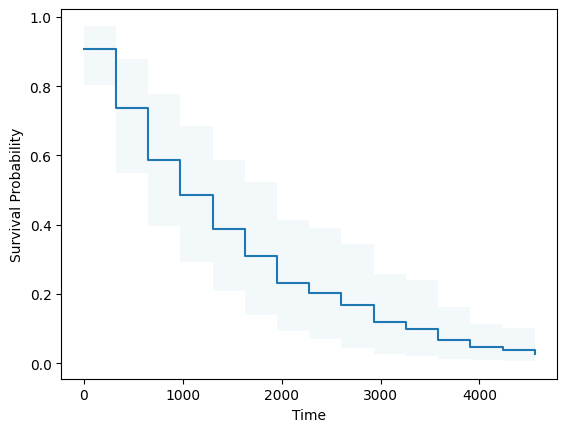

In [5]:
tis.visualize(mean_ , up_ , low_ , _from = 4 , _to = 5 )